In [ ]:
https://www.kaggle.com/code/ahb1104/neural-collaborative-filtering

## get dataset from goolge drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/1_try_/RS_book")
!ls

'Book Recommendation Dataset.zip'   DeepRec.png     recsys_taxonomy2.png
 Books.csv			    pytorch.ipynb   Untitled0.ipynb
 classicRec.png			    Ratings.csv     Users.csv


In [ ]:
# !unzip -q "Book Recommendation Dataset.zip"
# !ls

replace Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 'Book Recommendation Dataset.zip'   DeepRec.png     recsys_taxonomy2.png
 Books.csv			    pytorch.ipynb   Untitled0.ipynb
 classicRec.png			    Ratings.csv     Users.csv


In [ ]:
!cp /content/drive/MyDrive/1_try_/RS_book/Books.csv /content/
!cp /content/drive/MyDrive/1_try_/RS_book/Ratings.csv /content/
!cp /content/drive/MyDrive/1_try_/RS_book/Users.csv /content/

## kaggle

In [ ]:
import pandas as pd

books=pd.read_csv("/content/Books.csv",low_memory=False)
ratings=pd.read_csv("/content/Ratings.csv",low_memory=False)
users=pd.read_csv("/content//Users.csv",low_memory=False)

In [ ]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [ ]:
books.isnull().sum()


ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [ ]:
len(ratings)

1149780

In [ ]:
books_df=pd.read_csv("/content/Books.csv",low_memory=False)
ratings_df=pd.read_csv("/content/Ratings.csv",low_memory=False)
users_df=pd.read_csv("/content/Users.csv",low_memory=False)

LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit and transform user and item IDs
ratings['user_id'] = user_encoder.fit_transform(ratings['User-ID'])
ratings['item_id'] = item_encoder.fit_transform(ratings['ISBN'])

# Fit and transform user and item IDs
ratings_df['user_id'] = user_encoder.fit_transform(ratings_df['User-ID'])
ratings_df['item_id'] = item_encoder.fit_transform(ratings_df['ISBN'])

In [ ]:
ratings_train = ratings[0:919824]
ratings_test = ratings[919825:].reset_index(drop=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
class RatingDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'user_id': self.data['user_id'][idx],
            'book_id': self.data['item_id'][idx],
            'rating': self.data['Book-Rating'][idx]
        }

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Instantiate train and test datasets
train_dataset = RatingDataset(ratings_train)
test_dataset = RatingDataset(ratings_test)

# Create train and test loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(train_loader))

919824
14373


In [ ]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size):
        super(GMF, self).__init__()
        self.relu = nn.ReLU()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        self.fc = nn.Linear(embedding_size, 32)
        self.output_layer = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, user_ids, item_ids):
        user_embed = self.user_embedding(user_ids)
        item_embed = self.item_embedding(item_ids)
        element_product = user_embed * item_embed
        x = self.fc(element_product)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.output_layer(x)
        output = torch.sigmoid(output)  # Ensure output is between 0 and 1
        return output.view(-1)

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, hidden_layers=[64, 32]):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        layers = []
        input_size = embedding_size * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_layers[-1], 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, user_ids, item_ids):
        user_embed = self.user_embedding(user_ids)
        item_embed = self.item_embedding(item_ids)
        concat_embed = torch.cat((user_embed, item_embed), dim=1)
        output = self.layers(concat_embed)
        output = torch.sigmoid(output)  # Ensure output is between 0 and 1
        return output.view(-1)

In [ ]:
class NCF(nn.Module):
    def __init__(self, gmf_model, mlp_model):
        super(NCF, self).__init__()
        self.gmf = gmf_model
        self.mlp = mlp_model

    def forward(self, user_ids, item_ids):
        gmf_output = self.gmf(user_ids, item_ids)
        mlp_output = self.mlp(user_ids, item_ids)
        combined_output = (gmf_output + mlp_output) / 2
        return combined_output

In [ ]:
num_users = len(ratings['User-ID'].unique())
num_items = len(ratings['ISBN'].unique())
embedding_size = 64
hidden_layers = [128, 64, 32]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Initialize GMF model
gmf_model = GMF(num_users, num_items, embedding_size).to(device)

# Initialize MLP model
mlp_model = MLP(num_users, num_items, embedding_size, hidden_layers).to(device)

In [ ]:
#Loss criterion for GMF and MLP models
models_criterion = nn.MSELoss()

# Optimizer for GMF model
gmf_optimizer = optim.Adam(gmf_model.parameters(), lr=0.001)

# Optimizer for MLP model
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

In [ ]:
def train_gmf(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0.0
        i=0
        total_diff=0
        total_len=0
        for batch in dataloader:
            user_ids = batch['user_id'].to(device)
            item_ids = batch['book_id'].to(device)
            ratings = batch['rating'].to(device)

            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, (ratings.float()/10) )
            loss.backward()
            optimizer.step()

            if (i % 1000 == 0):
                actual_ratings = 10*predictions
                diff = torch.abs( actual_ratings - ratings ).sum().item()
                print(f'Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}, Avg. Diff: { (diff/len(ratings)) }')

            i = i + 1

            total_loss += loss.item()

        print(f'GMF Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader)}')

In [ ]:
def train_mlp(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0.0
        i=0
        for batch in dataloader:
            user_ids = batch['user_id'].to(device)
            item_ids = batch['book_id'].to(device)
            ratings = batch['rating'].to(device)

            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, (ratings.float()/10))
            loss.backward()
            optimizer.step()

            if (i % 1000 == 0):
                actual_ratings = 10*predictions
                diff = torch.abs( actual_ratings - ratings ).sum().item()
                print(f'Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}, Avg. Diff: { (diff/len(ratings)) }')

            i = i + 1

            total_loss += loss.item()

        print(f'MLP Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader)}')

In [ ]:
num_epochs = 3

print("Training GMF...")
train_gmf(gmf_model, train_loader, models_criterion, gmf_optimizer, num_epochs)

print("Training MLP...")
train_mlp(mlp_model, train_loader, models_criterion, mlp_optimizer, num_epochs)

Training GMF...
Batch [1/14373], Loss: 0.20831328630447388, Avg. Diff: 4.33951473236084
Batch [1001/14373], Loss: 0.15833786129951477, Avg. Diff: 3.644221305847168
Batch [2001/14373], Loss: 0.14095795154571533, Avg. Diff: 3.542548418045044
Batch [3001/14373], Loss: 0.15562985837459564, Avg. Diff: 3.6924285888671875
Batch [4001/14373], Loss: 0.12557071447372437, Avg. Diff: 3.2700376510620117
Batch [5001/14373], Loss: 0.11599335074424744, Avg. Diff: 3.1836767196655273
Batch [6001/14373], Loss: 0.15885818004608154, Avg. Diff: 3.6407132148742676
Batch [7001/14373], Loss: 0.13180813193321228, Avg. Diff: 3.2872154712677
Batch [8001/14373], Loss: 0.12217004597187042, Avg. Diff: 3.235283374786377
Batch [9001/14373], Loss: 0.1398754119873047, Avg. Diff: 3.2527527809143066
Batch [10001/14373], Loss: 0.12118864059448242, Avg. Diff: 3.0927233695983887
Batch [11001/14373], Loss: 0.17020156979560852, Avg. Diff: 3.7254559993743896
Batch [12001/14373], Loss: 0.15016885101795197, Avg. Diff: 3.387502908

In [ ]:
model = NCF(gmf_model, mlp_model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import math
num_epochs = 10
for epoch in range(num_epochs):
    i=0
    for batch in train_loader:
        user_ids = batch['user_id'].to(device)
        item_ids = batch['book_id'].to(device)
        ratings = batch['rating'].to(device)

        optimizer.zero_grad()
        predictions = model(user_ids, item_ids)
        loss = criterion(predictions, (ratings.float()/10))
        loss.backward()
        optimizer.step()

        if (i % 1000 == 0):
            actual_ratings = 10*predictions
            rmse = math.sqrt(torch.square(actual_ratings-ratings).sum().item()/len(ratings))
            diff = torch.abs( actual_ratings - ratings ).sum().item()
            print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item()}, Avg. Diff: { (diff/len(ratings)) }, RMSE: {rmse}')


        i = i + 1


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Batch [1/14373], Loss: 0.08808785676956177, Avg. Diff: 2.330751895904541, RMSE: 2.9679599714638867
Batch [1001/14373], Loss: 0.08022172749042511, Avg. Diff: 2.174924850463867, RMSE: 2.8323440694690407
Batch [2001/14373], Loss: 0.08313924074172974, Avg. Diff: 2.083922863006592, RMSE: 2.8833873971563513
Batch [3001/14373], Loss: 0.08672169595956802, Avg. Diff: 2.1996989250183105, RMSE: 2.944854619788463
Batch [4001/14373], Loss: 0.09062895178794861, Avg. Diff: 2.3576345443725586, RMSE: 3.010464220210397
Batch [5001/14373], Loss: 0.08294878154993057, Avg. Diff: 2.181122303009033, RMSE: 2.8800829859539543
Batch [6001/14373], Loss: 0.08068054914474487, Avg. Diff: 2.1832830905914307, RMSE: 2.840432212339007
Batch [7001/14373], Loss: 0.09116290509700775, Avg. Diff: 2.240917205810547, RMSE: 3.0193194750586203
Batch [8001/14373], Loss: 0.10987173765897751, Avg. Diff: 2.4459385871887207, RMSE: 3.3146904954225116
Batch [9001/14373], Loss: 0.06323565542697906, Avg. Diff: 1.8837368488311768, RMSE: 

In [ ]:
model.eval()

total_loss = 0
total_diff = 0
total_examples = 0
total_squared_error = 0

with torch.no_grad():
    for batch in test_loader:
        user_ids = batch['user_id'].to(device)
        item_ids = batch['book_id'].to(device)
        ratings = batch['rating'].to(device)

        predictions = model(user_ids, item_ids)
        loss = criterion(predictions, (ratings.float() / 10))

        actual_ratings = 10 * predictions
        diff = torch.abs(actual_ratings - ratings).sum().item()

        total_loss += loss.item() * len(ratings)
        total_diff += diff
        total_examples += len(ratings)
        total_squared_error += torch.square(actual_ratings-ratings).sum().item()

avg_loss = total_loss / total_examples
avg_diff = total_diff / total_examples
rmse = math.sqrt(total_squared_error / total_examples)

print('Evalution Measures:')
print(f'Evaluation Loss: {avg_loss}, Average Difference: {avg_diff}, RMSE: {rmse}')

Evalution Measures:
Evaluation Loss: 0.2532428097037124, Average Difference: 4.3443351952966545, RMSE: 5.032323596139187


In [ ]:
torch.save(model.state_dict(), '/content/model.pth')
model.state_dict()

OrderedDict([('gmf.user_embedding.weight',
              tensor([[-0.5624, -1.3819,  1.0367,  ...,  0.4001, -0.1564,  3.3780],
                      [ 2.2142,  1.0910,  1.4986,  ..., -0.7640, -0.6616, -0.1932],
                      [ 0.3840, -0.5114, -0.2803,  ...,  1.3857,  2.2816, -0.0465],
                      ...,
                      [-0.3778, -0.4525,  0.4108,  ...,  1.4215,  0.5195, -0.3969],
                      [ 0.0695, -0.1079, -1.6765,  ...,  0.6159,  0.6033,  0.3544],
                      [ 1.1817, -1.2852,  0.9386,  ..., -0.0533,  0.6412,  0.5811]],
                     device='cuda:0')),
             ('gmf.item_embedding.weight',
              tensor([[ 1.0159, -0.6526,  2.2748,  ..., -0.2538, -1.1148,  0.5335],
                      [-1.3188,  1.6271, -1.1525,  ..., -0.3318,  1.5256, -0.2490],
                      [ 0.3119, -0.2716,  0.7967,  ...,  0.8804, -0.8818, -0.3855],
                      ...,
                      [ 1.1299,  1.0908,  0.9183,  ...,  1.0843

In [ ]:
import time
for i in range(0,100):
    print(i)
    time.sleep(10)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


ณ mlp & GMF =3 คือด้านบน

ณ mlp & GMF =5 คือด้านล่าง


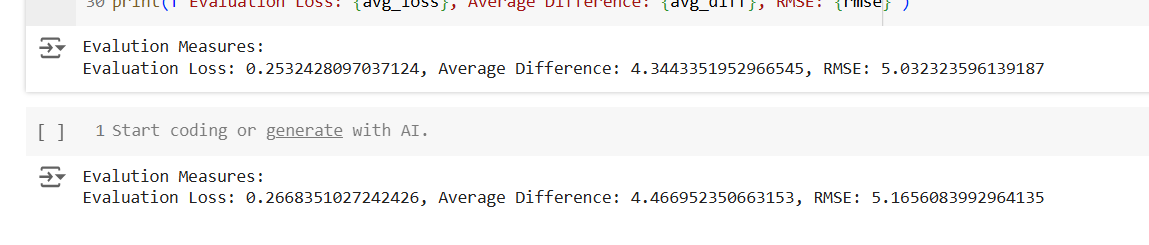

In [ ]:
# b=5

Evalution Measures:
Evaluation Loss: 0.2668351027242426, Average Difference: 4.466952350663153, RMSE: 5.1656083992964135


#Evaluation Measure¶
The average distance is the 'mean' of all differences between ground-truth and predicted
The RMSE is the root mean squared of error (highest RMSE=10 and lowest RMSE=0)

In [ ]:
users.head()


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users[users['User-ID'] == 276704]


,User-ID,Location,Age
276703,276704,"cedar park, texas, usa",NaN


We have chosen a random user from the dataset. This user is from Texas, USA¶
Next, we will choose the top 64 rated books in our database and then recommend 3 books to this user¶

In [ ]:
book_ratings = ratings_df.groupby('item_id')['Book-Rating'].mean().reset_index()
book_ratings = book_ratings.sort_values(by='Book-Rating', ascending=False)
top_64_books = book_ratings.head(64)
print(top_64_books)

        item_id  Book-Rating
179431   179431         10.0
179429   179429         10.0
68077     68077         10.0
340350   340350         10.0
340429   340429         10.0
...         ...          ...
251580   251580         10.0
251274   251274         10.0
251590   251590         10.0
251593   251593         10.0
251637   251637         10.0

[64 rows x 2 columns]


In [ ]:
user_id = 276704
user_id_tensor = torch.LongTensor([user_id] * 64).to(device)

top_64_books = top_64_books['item_id'].tolist()
item_ids_tensor = torch.LongTensor(top_64_books).to(device)

print("User ID Tensor:", user_id_tensor)
print("Top 10 Books Tensor:", item_ids_tensor)

User ID Tensor: tensor([276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704, 276704,
        276704], device='cuda:0')
Top 10 Books Tensor: tensor([179431, 179429,  68077, 340350, 340429,  68362,  68395,  68354,  68338,
        340469,     67,     52,     53,     54, 340461, 179453, 251314,  30015,
        251390,  30007, 251318, 148441, 148430, 148435,  29980, 251312, 251313,
        148426,  56646,  56649, 148445, 179544, 179476, 179504, 179405, 179409,
        179505, 179517, 340309,    132, 179538,  

In [ ]:
predictions = model(user_id_tensor, item_ids_tensor)

indexed_predictions = [(idx, pred) for idx, pred in enumerate(predictions)]

# Sort the indexed predictions by the prediction values in descending order
sorted_predictions = sorted(indexed_predictions, key=lambda x: x[1], reverse=True)

# Get the top 3 indices
top_3_indices = [idx for idx, _ in sorted_predictions[:3]]

# Get the top 3 book ISBNs
top_3_book_isbns = [item_ids_tensor[idx].item() for idx in top_3_indices]

print("Top 3 Book ISBNs:", top_3_book_isbns)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
